In [2]:
import polytope
import scipy
import matplotlib
import matplotlib.pyplot as plt
import tqdm
import warnings
import itertools
import numpy as np
import cvxpy as cp
from scipy.stats import norm
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', size=20)
plt.rc('font', family='Times New Roman')
# plt.rc('fontname', "Times New Roman")
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'

## Quantile Regression

In [3]:
def regress_quantile(tau, X, Y):
    """
    tau \in (0,1) is the desired quantile
    X \in \R^{n \times d} is the data matrix
    Y \in \R^n is the label vector
    """
    (n, d) = X.shape
    w = cp.Variable(d)
    u = cp.Variable(n)
    v = cp.Variable(n, nonneg=True)
    
    constraints = [u == Y - X @ w, v >= - u]
    objective = cp.Minimize(tau * np.ones(n) @ u + np.ones(n) @ v)
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return w.value, prob.value

def conformalize_quantiles(w1, w2, X_calibrate, Y_calibrate, conf):
    n = len(Y_calibrate)
    s = np.maximum(X_calibrate @ w1 - Y_calibrate, Y_calibrate - X_calibrate @ w2)
    quant = int(np.floor((n + 1) * (conf)))
    q = np.sort(s)[quant]
    return q, quant / n

### Setup a simple regression example:

In [4]:
n = 100
# sigma_x = 4
sigma_y = 1
low = -10
high = 10
w_true = np.array([.5, .5, 2, 3])
x = np.random.uniform(low=low, high=high, size=n)
get_X = lambda x:  np.vstack((np.ones(len(x)), x, np.sin(x/4 - 2.4), np.cos(x /2))).T
X = get_X(x)
Y = X @ w_true + np.random.randn(n) * sigma_y

def get_true_quantiles(x, tau):
    X = get_X(x)
    y = X @ w_true
    epsilon = norm.ppf(tau, scale=sigma_y)
    return y + epsilon

### Fit Quantiles

In [5]:
w05, _= regress_quantile(0.05, X, Y)
w95, _= regress_quantile(0.95, X, Y)
w50, _= regress_quantile(0.5, X, Y)

### Calibrate quantiles with 20% new calibration data

In [6]:
n_calibrate = int(np.floor(.2 * n))
x_calibrate = np.random.uniform(low=low, high=high, size=n_calibrate)
X_calibrate = get_X(x_calibrate)
Y_calibrate = X_calibrate @ w_true + np.random.randn(n_calibrate) * sigma_y

q, prob = conformalize_quantiles(w05, w95, X_calibrate, Y_calibrate, .9)

### Plot Results

In [7]:
xx = np.linspace(low, high, num=n)
XX = get_X(xx)
yy = XX @ w_true

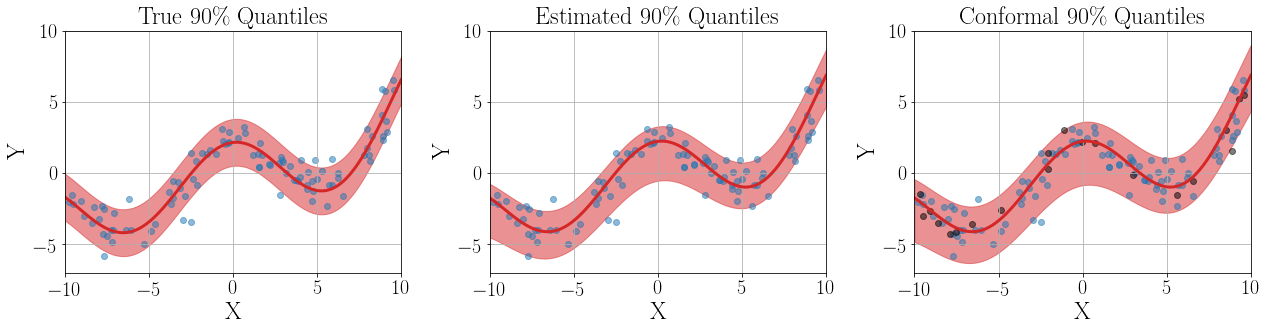

In [8]:
fig, axs = plt.subplots(1,3, figsize=(18,5))

axs[0].plot(xx, yy, "tab:red", lw=3)
axs[0].fill_between(xx, get_true_quantiles(xx, .05), get_true_quantiles(xx, .95), color="tab:red", alpha=.5, )
axs[0].scatter(x, Y, alpha=.5)
axs[0].set_xlim(low, high)
axs[0].set_ylim(-7, high)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].grid()
axs[0].set_title("True 90\% Quantiles")

axs[1].plot(xx, XX @ w50, "tab:red", lw=3)
axs[1].fill_between(xx, XX @ w05, XX @ w95, color="tab:red", alpha=.5)
# axs[1].fill_between(xx, XX @ w05 - q, XX @ w95 + q, color="tab:orange", alpha=.4)
axs[1].scatter(x, Y, alpha=.5)
axs[1].set_xlim(low, high)
axs[1].set_ylim(-7, high)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].grid()
axs[1].set_title("Estimated 90\% Quantiles")

axs[2].plot(xx, XX @ w50, "tab:red", lw=3)
axs[2].fill_between(xx, XX @ w05 - q, XX @ w95 + q, color="tab:red", alpha=.5)
axs[2].scatter(x, Y, alpha=.5)
axs[2].scatter(x_calibrate, Y_calibrate, alpha=.5, c="k")
axs[2].set_xlim(low, high)
axs[2].set_ylim(-7, high)
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
axs[2].grid()
axs[2].set_title("Conformal 90\% Quantiles")
plt.tight_layout()

## Heteroskedastic data

In [9]:
sigma_yh = lambda x: sigma_y + 0.3 * np.maximum(x, 0)
x = np.random.uniform(low=low, high=high, size=n)
X = get_X(x)
Y = X @ w_true + np.random.randn(n) * sigma_yh(x)

def get_true_quantiles_h(x, tau):
    X = get_X(x)
    y = X @ w_true
    epsilons = [norm.ppf(tau, scale=sy) for sy in sigma_yh(x)]
    return y + np.array(epsilons)

### Fit Quantiles

In [10]:
w05, _= regress_quantile(0.05, X, Y)
w95, _= regress_quantile(0.95, X, Y)
w50, _= regress_quantile(0.5, X, Y)

### Calibrate Quantiles with 20% new calibration data

In [11]:
n_calibrate = int(np.floor(.2 * n))
x_calibrate = np.random.uniform(low=low, high=high, size=n_calibrate)
X_calibrate = get_X(x_calibrate)
Y_calibrate = X_calibrate @ w_true + np.random.randn(n_calibrate) * sigma_yh(x_calibrate)

q, prob = conformalize_quantiles(w05, w95, X_calibrate, Y_calibrate, .9)
print(q)

0.9667085373451085


### Plot results

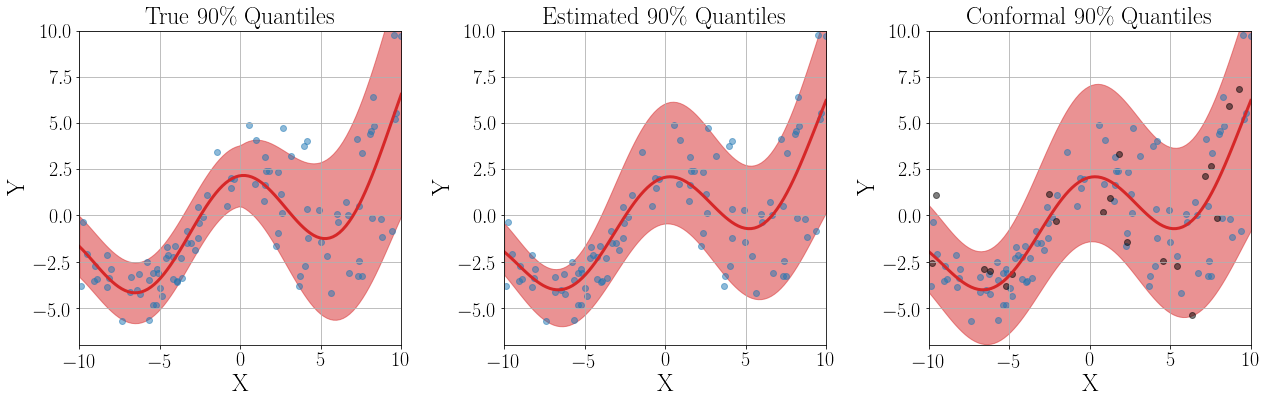

In [12]:
fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].plot(xx, yy, "tab:red", lw=3)
axs[0].fill_between(xx, get_true_quantiles_h(xx, .05), get_true_quantiles_h(xx, .95), color="tab:red", alpha=.5, )
axs[0].scatter(x, Y, alpha=.5)
axs[0].set_xlim(low, high)
axs[0].set_ylim(-7, high)
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].grid()
axs[0].set_title("True 90\% Quantiles")

axs[1].plot(xx, XX @ w50, "tab:red", lw=3)
axs[1].fill_between(xx, XX @ w05, XX @ w95, color="tab:red", alpha=.5)
# axs[1].fill_between(xx, XX @ w05 - q, XX @ w95 + q, color="tab:orange", alpha=.4)
axs[1].scatter(x, Y, alpha=.5)
axs[1].set_xlim(low, high)
axs[1].set_ylim(-7, high)
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].grid()
axs[1].set_title("Estimated 90\% Quantiles")

axs[2].plot(xx, XX @ w50, "tab:red", lw=3)
axs[2].fill_between(xx, XX @ w05 - q, XX @ w95 + q, color="tab:red", alpha=.5)
axs[2].scatter(x, Y, alpha=.5)
axs[2].scatter(x_calibrate, Y_calibrate, alpha=.5, c="k")
axs[2].set_xlim(low, high)
axs[2].set_ylim(-7, high)
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
axs[2].grid()
axs[2].set_title("Conformal 90\% Quantiles")
plt.tight_layout()